In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels as sm
import pmdarima as pm

In [3]:
df = pd.read_csv("../prices.txt", sep='\s+', header=None, index_col=None)
df.rename(columns=lambda c: str(c), inplace=True)
# df["time"] = pd.to_datetime([i for i in range(500)], unit='D', origin=pd.Timestamp('2020-01-01'))
# df.set_index("time", inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,13.46,71.65,48.46,50.52,52.10,13.00,18.98,47.71,69.49,49.96,...,32.64,55.76,14.46,58.94,36.71,52.62,49.33,36.22,49.00,56.09
1,13.48,72.10,48.52,50.50,52.06,12.95,18.95,47.84,69.73,49.93,...,32.52,55.97,14.44,59.81,36.64,52.58,49.20,36.27,48.84,56.08
2,13.47,72.35,48.48,50.62,51.80,12.79,18.98,47.98,69.60,49.33,...,32.48,56.34,14.50,59.04,36.89,52.49,49.48,36.39,48.56,55.90
3,13.53,72.51,48.42,50.75,51.66,12.66,18.96,48.74,69.54,49.67,...,32.59,56.32,14.40,58.73,36.94,52.40,49.42,36.41,49.00,56.14
4,13.64,71.99,48.40,50.65,51.97,12.62,18.89,48.88,69.68,49.46,...,32.64,56.32,14.36,59.01,37.03,52.44,49.79,36.42,48.14,55.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,10.32,63.28,45.54,43.35,52.64,7.91,17.30,55.30,67.83,58.73,...,28.81,79.78,10.85,61.76,30.12,48.51,82.09,34.95,35.80,52.57
746,10.32,63.34,45.56,43.28,52.73,7.87,17.26,54.92,67.95,58.62,...,28.78,80.46,10.77,61.49,29.85,48.40,81.43,34.99,35.58,53.10
747,10.32,63.23,45.55,43.25,52.66,7.83,17.32,54.67,67.94,59.15,...,28.73,81.15,10.75,60.36,29.77,48.41,81.90,35.00,35.45,53.21
748,10.20,63.12,45.56,43.19,52.51,7.71,17.33,55.18,67.99,59.64,...,28.73,82.22,10.81,59.24,29.61,48.42,81.33,35.19,35.57,53.01


In [4]:
train = df.iloc[:350, :]
test = df.iloc[350:, :]

In [5]:
from arch.unitroot.cointegration import engle_granger
from scipy.optimize import minimize
from statsmodels.tsa.vector_ar.vecm import VECM

In [6]:
from statsmodels.tsa.stattools import coint

In [91]:
def find_cointegrated_pairs(data):
    n = 50
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[str(i)]
            S2 = data[str(j)]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.005:
                pairs.append((str(i), str(j)))
    return score_matrix, pvalue_matrix, pairs

In [88]:
scores, pvalues_train, pairs_train = find_cointegrated_pairs(train)
scores, pvalues_test, pairs_test = find_cointegrated_pairs(test)

KeyboardInterrupt: 

In [94]:
scores, pvalues_train, pairs_train = find_cointegrated_pairs(df.apply(np.log).iloc[:500])
pairs_train

[('1', '10'), ('7', '24'), ('7', '49'), ('27', '36'), ('28', '39')]

In [50]:
1-(1-0.0001)**(50*49/2)

0.11529951422485696

In [64]:
import seaborn
# plt.figure()
# seaborn.heatmap(pvalues_train, cmap='RdYlGn_r', mask=(pvalues_train >= 0.1))
# plt.figure()
# seaborn.heatmap(pvalues_test, cmap='RdYlGn_r', mask=(pvalues_test >= 0.1))
set(pairs_train).intersection(set(pairs_test))

{('12', '42'), ('20', '25')}

0.00926655657202666


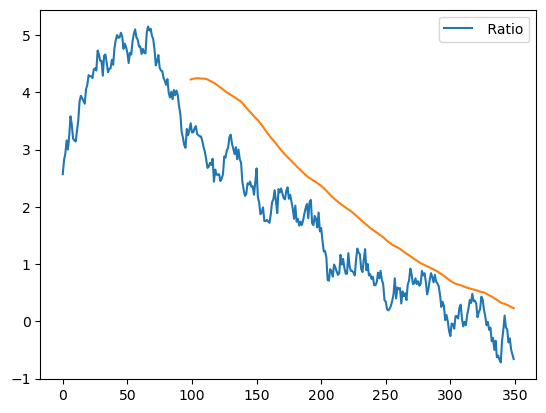

In [53]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

S1 = train['12']
S2 = train['15']
score, pvalue, _ = coint(S1, S2)
print(pvalue)

ratios = S1 - S2
ratios.plot()
ratios.rolling(100).mean().plot()
# zs= zscore(ratios)
# zs.plot()
# plt.axhline(zs.mean())
# plt.axhline(-1, color='green')
# plt.axhline(1, color='red')
plt.legend([' Ratio'])
plt.show()

In [67]:
logprice = np.log(train)
logprice_test = np.log(test)

In [551]:
from arch.unitroot import ADF

for i in range(50):
    t1 = str(i)

    result = ADF(logprice[t1], trend='c')
    if result.pvalue < 0.05:
        print(t1, result.pvalue)

7 0.014875699022375247
9 0.008083678333603525
28 0.04712327342788253
43 0.0063368519532042795
49 0.005026804206181825


<Axes: xlabel='time'>

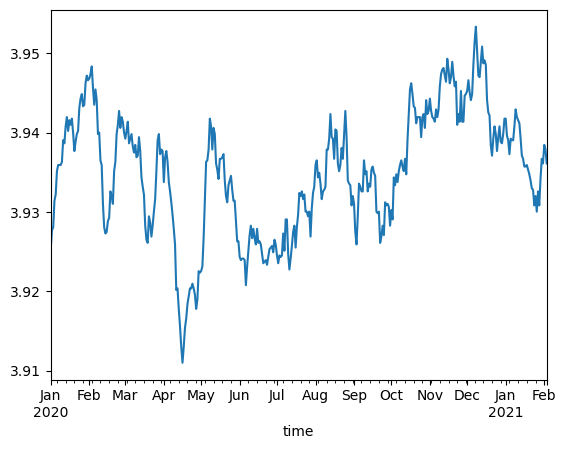

In [558]:
logprice['28'].plot()

In [1272]:
exclude = {14,30,11,42,1,10,4,32,24,49,22,47,15,16,38,9,21,35,7,17,25}
for i in range(50):
    for j in range(i+1,50):
        for k in range(j+1,50):
            if i in exclude or j in exclude or k in exclude:
                continue
      
            t1, t2, t3 =  str(i), str(j), str(k)
            result = engle_granger((np.log(df))[t1], (np.log(df))[[t2,t3]], trend='c', method='bic')
            # result2 = engle_granger((logprice_test)[t1], (logprice_test)[[t2,t3]], trend='c', method='bic')
            if result.pvalue < 0.02 and result.pvalue > 0.01:
                print(t1,t2,t3,result.pvalue)

0 33 46 0.015879536706387896
2 20 33 0.013829479580833571
13 18 40 0.01265534716864309
27 28 36 0.013800139736605599
27 40 44 0.01008936617524122
28 31 39 0.015160707092851819
28 33 39 0.017826963604665545
28 37 39 0.012996463760917891
28 39 40 0.016057858223910218
28 39 46 0.010365263917811163
28 39 48 0.01756234031796524
28 41 48 0.017863045251560475
28 43 48 0.019040752117370736
36 39 41 0.016933305732326626
43 44 46 0.017699157339596327
43 45 46 0.017973481568992335
43 46 48 0.017212709938586465


[0.32971776797284735, -0.5696967968104495, -0.10058543521670305]


<Axes: xlabel='time'>

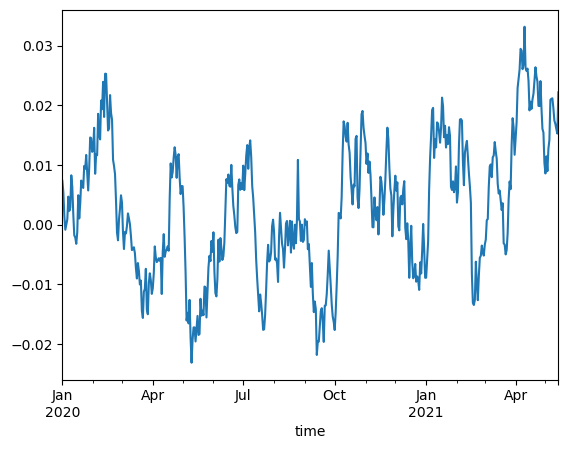

In [1279]:
t1,t2,t3= '9','21','35'
indices = [t1,t2,t3]
result = engle_granger(logprice[t1],logprice[[t2,t3]], trend='c', method='bic')
weights = result.cointegrating_vector[:3]


beta = weights.values
beta /= np.sum(np.abs(beta))
print(list(beta.T))

spread = logprice[indices] @ beta
also = (np.log(df))[indices] @ beta
(also-np.mean(spread)).plot()

In [1206]:
exclude = {11,42,1,10,7,8,33,37,4,32, 28,39,24,49,14,30,17,43,24,49,22,47}
exclude_pairs = {(43,49), (15,20),(14,30),(22,24),(25,36),(31,40),(9,46),(13,45),(44,47)}
risky = {(2,12),(2,15), (12,16)}
nope = {(3,18), (5,13), (5,45),(12,15),(25,34),(43,44),(43,45),(43,46)}
for i in range(50):
    for j in range(i+1,50):
        if i in exclude or j in exclude:
            continue
        if (i,j) in exclude_pairs or (i,j) in risky or (i,j) in nope:
            continue

        t1, t2 =  str(i), str(j)
        result = engle_granger(logprice[t1], logprice[t2], trend='n', method='bic')
        # result2 = engle_granger(np.log(df)[t1], (np.log(df))[t2], trend='n', method='bic')
        if result.pvalue > 0.1 and result.pvalue < 0.15:
            print(t1,t2,result.pvalue)

2 5 0.1357072607821727
2 13 0.14590254959446652
2 44 0.10075102704641936
5 12 0.10715214100559356
5 16 0.11246500523006386
5 26 0.11197445649461724
5 27 0.13881299235583155
6 12 0.10380970610505519
6 13 0.12569200864331764
6 44 0.12343641068167893
6 45 0.14795247700323272
9 19 0.1236010546499236
13 29 0.13487945536848744
13 31 0.1007598228762337
13 38 0.11490911558927702
15 36 0.1305443213155546
19 48 0.14909011432043773
21 40 0.14799219946894981
23 48 0.14431437952178544
27 44 0.10084864682965189
36 46 0.11462591253799143
38 44 0.12074513289782224
40 48 0.14191552592451223


In [506]:
coint_result = engle_granger(logprice['3'], logprice['45'], trend="ct", method='bic')
weight = coint_result.cointegrating_vector[:2]
weight

3     1.000000
45   -0.664413
dtype: float64

In [78]:
t1, t2 = '20', '25'
indices = [t1,t2]

<Axes: >

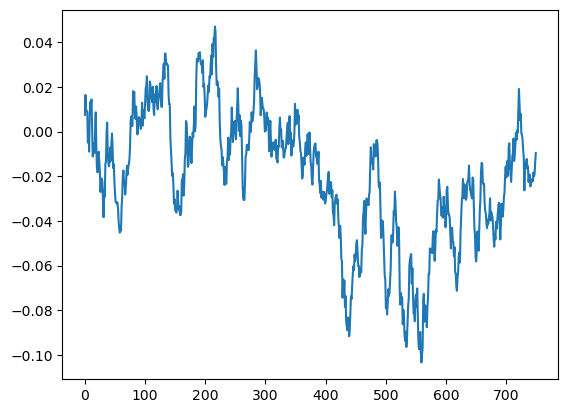

In [79]:
coint_result = engle_granger(logprice[t1], logprice[t2], trend="c", method='bic')
weight = coint_result.cointegrating_vector[:2]
coint_result

beta = weight.values
beta /= np.sum(np.abs(beta))
beta 

spread = logprice[indices] @ beta
also = (np.log(df))[indices] @ beta
(also-np.mean(spread)).plot()

In [69]:
beta = weight.values
beta /= np.sum(np.abs(beta))
beta 

array([ 0.83308612, -0.16691388])

<Axes: >

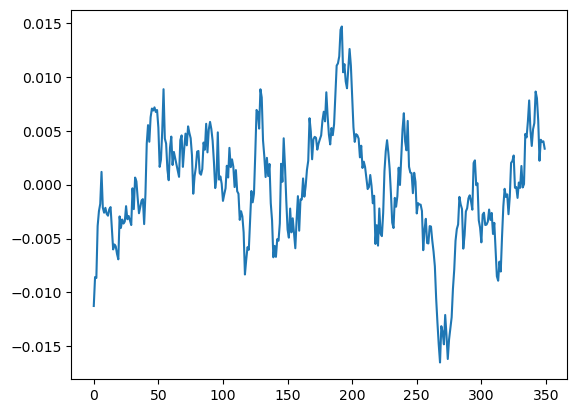

In [70]:
# beta = vecm_result.beta
spread = logprice[indices] @ beta

(spread-np.mean(spread)).plot()

<Axes: >

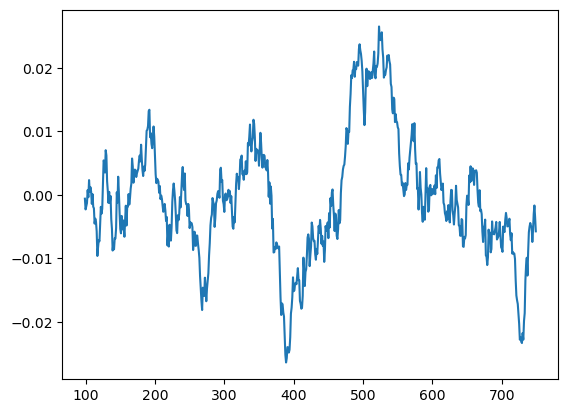

In [71]:
also = (np.log(df))[indices] @ beta
(also-also.rolling(100).mean()).plot()

In [72]:
spread = spread - np.mean(spread)

In [1296]:
f_star.T[0]

array([0.4934463373994802, 0.48117838908467403, 0.46151740128311414,
       0.4405166719075254, 0.42288975729660416, 0.4052954571251444,
       0.38728232836454407, 0.3651229565399163, 0.3423722555409188,
       0.3219938100828405, 0.30360917470760257, 0.2831194283256816,
       0.26003482455515653, 0.24269933105407374, 0.2280631686070646,
       0.2129187461956918, 0.20212164140858196, 0.1905890351729113,
       0.17821689268158056, 0.16406164287183053, 0.15396803593391092,
       0.14069960778704513, 0.1309879302843674, 0.12369275449462856,
       0.11437604748523253, 0.10514967367535467, 0.09821583068368869,
       0.0894978183757114, 0.08170619587201698, 0.07562076924033956,
       0.07087039756328734, 0.06556185202095104, 0.06010087278528009,
       0.05474076633488919, 0.046978569076530356, 0.040480655180416165,
       0.03732053932186101, 0.03433810564230975, 0.03140806331935391,
       0.02845751288718057, 0.02539304677075923, 0.02200734171081141,
       0.017771835504532135, 0

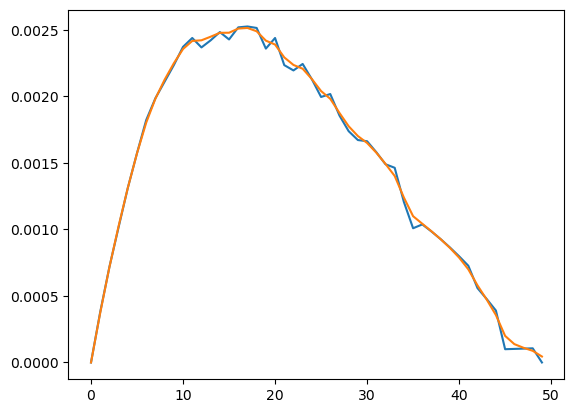

In [1301]:
plt.plot(np.multiply(f_bar, s0))
plt.plot(np.multiply(f_star.T[0], s0))

The optimal threshold is 0.003590003969760792


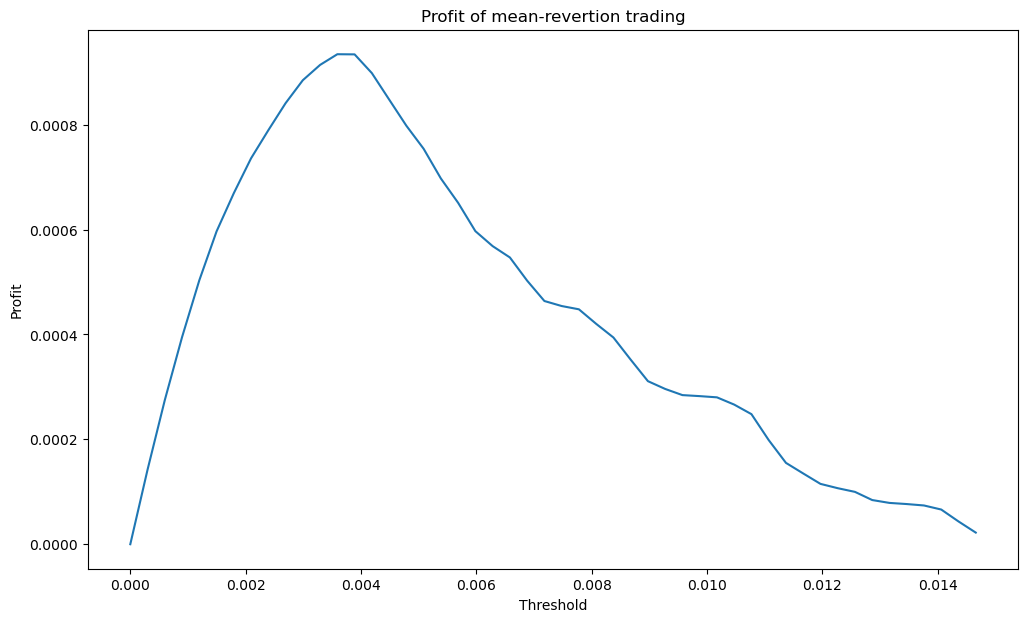

In [73]:
s0 = np.linspace(0, spread.max(), 50)
f_bar = np.array([None]*50)
for i in range(50):
    f_bar[i] = len(spread.values[spread.values > s0[i]]) / spread.shape[0]

D = np.zeros((49, 50))
for i in range(D.shape[0]):
    D[i, i] = 1
    D[i, i+1] = -1

l = 1.0
f_star = np.linalg.inv(np.eye(50) + l * D.T@D) @ f_bar.reshape(-1, 1)
s_star = [f_star[i]*s0[i] for i in range(50)]

threshold = s0[s_star.index(max(s_star))]
print(f"The optimal threshold is {threshold}")

plt.figure(figsize=(12, 7))
plt.plot(s0, s_star)
plt.title("Profit of mean-revertion trading")
plt.xlabel("Threshold")
plt.ylabel("Profit")
plt.show()


In [75]:
# testing
train_spread = (np.log(train))[[t1,t2]] @ beta
spread = (np.log(test))[[t1,t2]] @ beta
normalized = spread - np.mean(train_spread)

<Figure size 640x480 with 0 Axes>

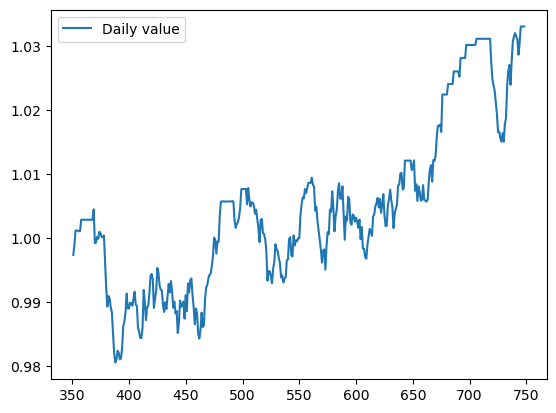

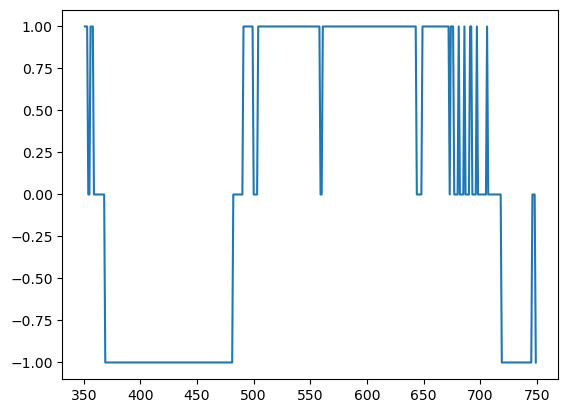

In [76]:
trading_weight = beta
trading_weight /= np.sum(abs(trading_weight))

testing_ret = test[[t1,t2]].pct_change().iloc[1:].shift(-1)   # Shift 1 step backward as forward return result
equity = pd.DataFrame(np.ones((testing_ret.shape[0], 1)), index=testing_ret.index, columns=["Daily value"])

retspread = normalized.iloc[1:]
buy_period = retspread[retspread < -threshold].dropna().index
sell_period = retspread[retspread > threshold].dropna().index
# print(retspread[retspread < -threshold])

# print(equity.loc[buy_period, "Daily value"])
# print(testing_ret.loc[buy_period] @ trading_weight + 1)
equity.loc[buy_period, "Daily value"] = (testing_ret.loc[buy_period] @ trading_weight + 1)
equity.loc[sell_period, "Daily value"] = (testing_ret.loc[sell_period] @ -trading_weight + 1)

plt.figure()
value = equity.cumprod()
value.plot()
plt.figure()
# plt.plot(retspread[retspread < -threshold].astype('int') - retspread[retspread > threshold].astype('int'))
plt.plot((retspread > threshold).astype('int') - (retspread < -threshold).astype('int'))
# plt.plot(-retspread[retspread < -threshold].notnull().astype('int'))


In [77]:
print(threshold)
print(list(trading_weight.T))
print(np.mean(train_spread))

0.003590003969760792
[0.8330861225033825, -0.16691387749661749]
2.3163047339573013


In [1065]:
t1, t2

('26', '36')

In [946]:
list(trading_weight.T)

[0.6305726535836199, -0.36942734641638003]

In [518]:
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [539]:
scaler = MinMaxScaler(feature_range = (0, 1))
nn = pd.DataFrame(scaler.fit_transform(df['6'].values.reshape(-1,1)), index=df.index)
input_ = nn[:-1]
output = nn.shift(-1).iloc[:-1]

splitter = int(input_.shape[0] * 0.7)
X_train = input_.iloc[:splitter]
X_test = input_.iloc[splitter:]
y_train = output.iloc[:splitter]
y_test = output.iloc[splitter:]

In [540]:
features_set = []
labels = []
for i in range(60, X_train.shape[0]):
    features_set.append(X_train.iloc[i-60:i].values.reshape(-1, 1))
    labels.append(y_train.iloc[i])
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

In [541]:
model = Sequential()
# Add our first LSTM layer - 50 nodes.
model.add(LSTM(units = 50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
# Add Dropout layer to avoid overfitting
model.add(Dropout(0.2))
# Add additional layers
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 5))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae', 'acc'])
callback = EarlyStopping(monitor='loss', patience=3, verbose=1, restore_best_weights=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                

In [542]:
model.fit(features_set, labels, epochs = 50, batch_size = 100, callbacks=[])

Epoch 1/50
3/3 [==============================] - 4s 106ms/step - loss: 0.1391 - mae: 0.3345 - acc: 0.0000e+00
Epoch 2/50
3/3 [==============================] - 0s 102ms/step - loss: 0.0319 - mae: 0.1419 - acc: 0.0000e+00
Epoch 3/50
3/3 [==============================] - 0s 105ms/step - loss: 0.0261 - mae: 0.1269 - acc: 0.0000e+00
Epoch 4/50
3/3 [==============================] - 0s 99ms/step - loss: 0.0207 - mae: 0.1146 - acc: 0.0000e+00
Epoch 5/50
3/3 [==============================] - 0s 105ms/step - loss: 0.0254 - mae: 0.1271 - acc: 0.0000e+00
Epoch 6/50
3/3 [==============================] - 0s 98ms/step - loss: 0.0166 - mae: 0.1028 - acc: 0.0000e+00
Epoch 7/50
3/3 [==============================] - 0s 101ms/step - loss: 0.0144 - mae: 0.0976 - acc: 0.0000e+00
Epoch 8/50
3/3 [==============================] - 0s 99ms/step - loss: 0.0160 - mae: 0.1018 - acc: 0.0000e+00
Epoch 9/50
3/3 [==============================] - 0s 104ms/step - loss: 0.0117 - mae: 0.0866 - acc: 0.0000e+00
Epoc

In [543]:
test_features = []
for i in range(60, X_test.shape[0]):
    test_features.append(X_test.iloc[i-60:i].values.reshape(-1, 1))
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

10/10 [==============================] - 0s 16ms/step


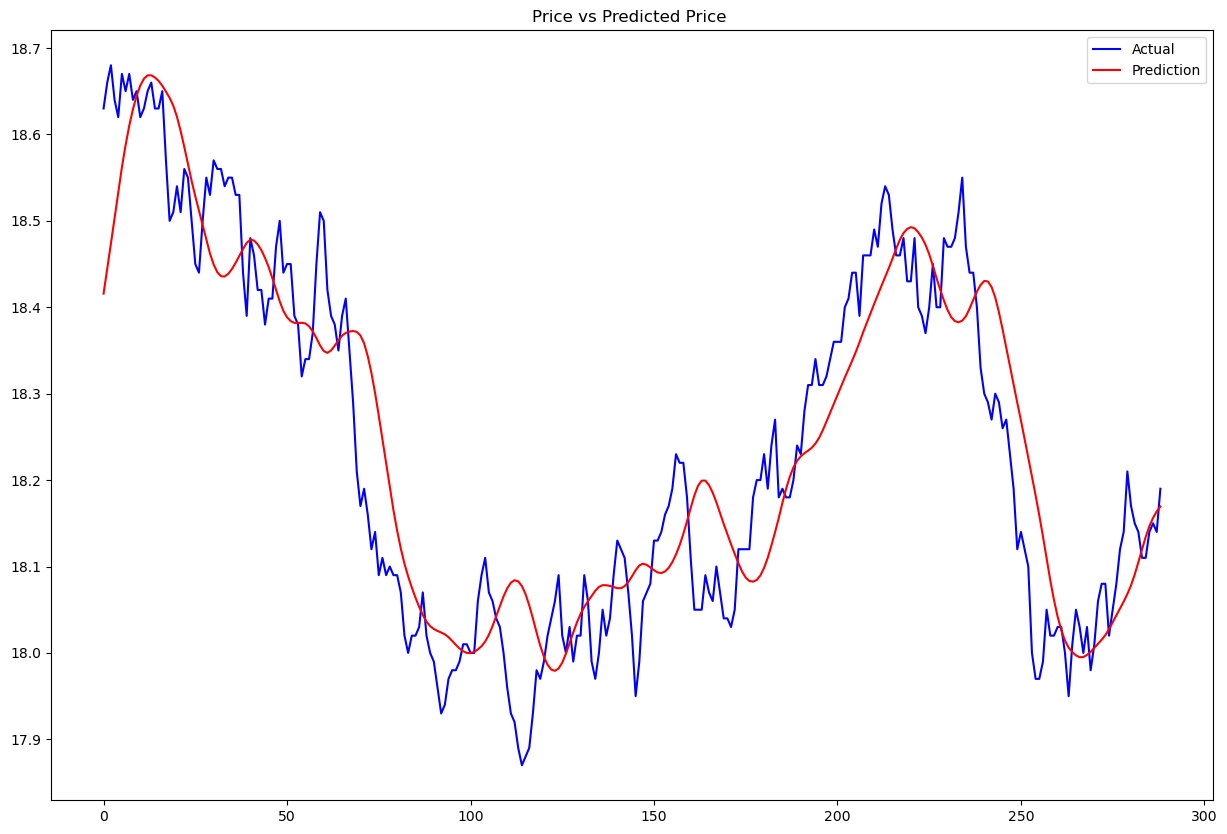

In [546]:
predictions = model.predict(features_set)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_train.values)
plt.figure(figsize=(15, 10))
plt.plot(actual[60:], color='blue', label='Actual')
plt.plot(predictions , color='red', label='Prediction')
plt.title('Price vs Predicted Price ')
plt.legend()
plt.show()

In [669]:
classifier = test.le(test.rolling(30).mean() - test.rolling(30).std())

In [646]:
from scipy.stats import norm, zscore

In [670]:
z_score = test.apply(zscore)[classifier]
magnitude = -z_score * test.rolling(30).std() / test.shift(1)
confidence = (-z_score).apply(norm.cdf)

In [671]:
magnitude.fillna(0, inplace=True)
confidence.fillna(0, inplace=True)

In [672]:
weight = confidence - 1 / (magnitude + 1)
weight = weight[weight > 0].fillna(0)
sum_ = np.sum(weight, axis=1)
for i in range(weight.shape[0]):
    if sum_[i] > 0:
        weight.iloc[i] = weight.iloc[i] / sum_[i]
    else:
        weight.iloc[i] = 0
weight = weight.iloc[:-1]

In [673]:
weight.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,299.0,299.0,299.0,299.0,299.0,299.000000,299.0,299.000000,299.0,299.000000,...,299.0,299.0,299.000000,299.0,299.000000,299.000000,299.0,299.0,299.000000,299.0
mean,0.0,0.0,0.0,0.0,0.0,0.006171,0.0,0.013378,0.0,0.003344,...,0.0,0.0,0.012238,0.0,0.016390,0.000791,0.0,0.0,0.035164,0.0
std,0.0,0.0,0.0,0.0,0.0,0.035506,0.0,0.115079,0.0,0.057831,...,0.0,0.0,0.060887,0.0,0.096113,0.005698,0.0,0.0,0.174211,0.0
min,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
max,0.0,0.0,0.0,0.0,0.0,0.450048,0.0,1.000000,0.0,1.000000,...,0.0,0.0,0.411264,0.0,1.000000,0.052555,0.0,0.0,1.000000,0.0


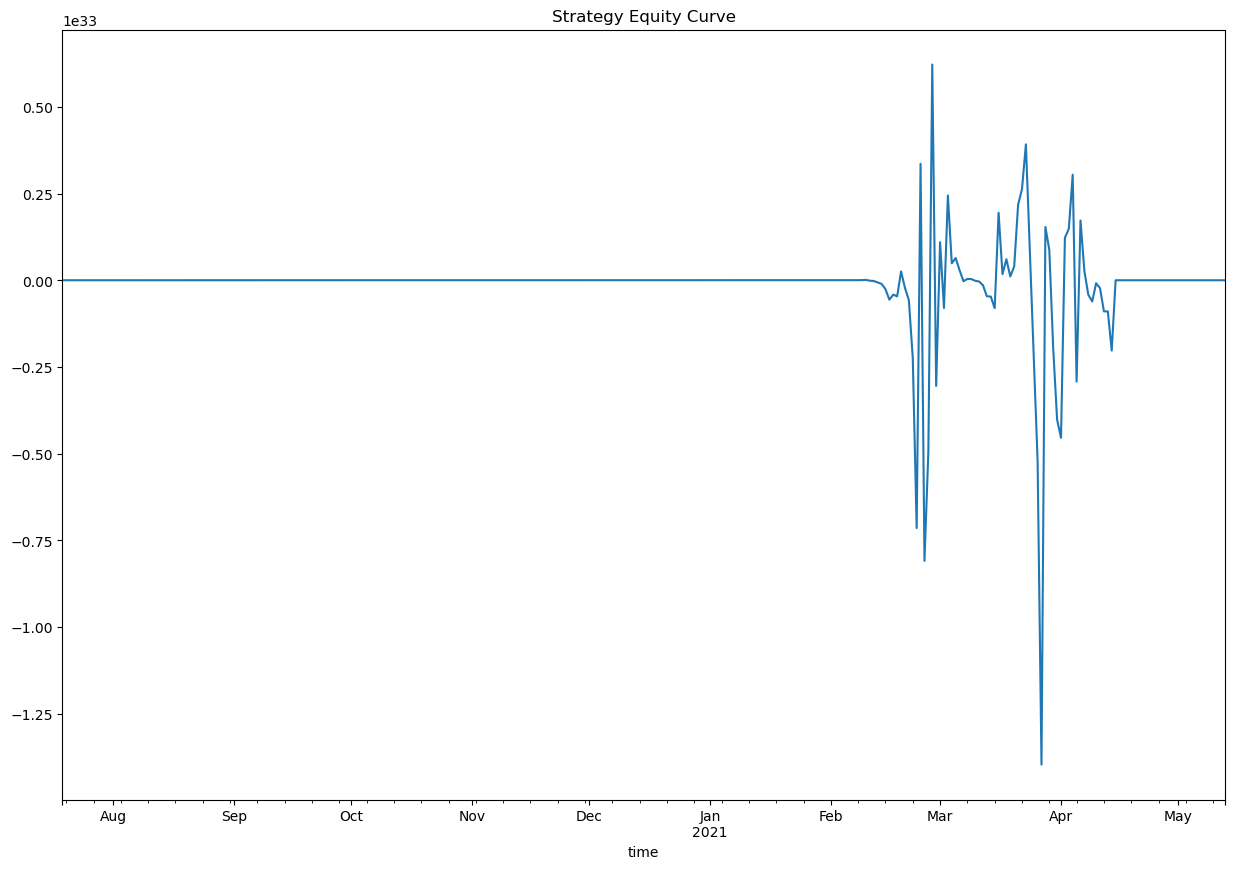

In [674]:
ret = pd.Series(index=range(test.shape[0] - 1))
for i in range(test.shape[0] - 1):
    ret[i] = test.iloc[i] @ test.pct_change().iloc[i + 1].T

total_ret = (ret + 1).cumprod()
total_ret.index = weight.index
total_ret.plot(title='Strategy Equity Curve', figsize=(15, 10))
plt.show()